<a href="https://colab.research.google.com/github/keehyun2/TestPy/blob/master/colab/5-2-v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 교차 검증과 그리드 서치

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/hg-mldl/blob/master/5-2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

## 검증 세트

In [192]:
import pandas as pd

wine = pd.read_csv('https://bit.ly/wine_csv_data')

In [193]:
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

In [194]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)

In [195]:
sub_input, val_input, sub_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

In [196]:
print(sub_input.shape, val_input.shape)

(4157, 3) (1040, 3)


In [197]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)

print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))

0.9971133028626413
0.864423076923077


In [198]:
# 전체 데이터셋
# ┌─────────────────────────────┐
# │                      전체 데이터 (100%)                  │
# └─────────────────────────────┘
#                          ↓
# 1단계: Train / Test 분할 (예: 80% / 20%)
# ┌───────────────┐ ┌────────────┐
# │         Train (80%)          │ │ Test (20%)             │
# └───────────────┘ └────────────┘
#                          ↓
# 2단계: Train → Sub-train / Validation 분할 (예: 64% / 16%)
# ┌───────┐ ┌───────┐
# │ Sub-train    │ │ Validation   │
# │ (64%)        │ │ (16%)        │
# └───────┘ └───────┘


## 교차 검증

In [199]:
from sklearn.model_selection import cross_validate
# dt = DecisionTreeClassifier(random_state=42)
scores = cross_validate(dt, train_input, train_target)
print(scores)

{'fit_time': array([0.00879502, 0.00841856, 0.01092386, 0.00915742, 0.00856853]), 'score_time': array([0.00132751, 0.00133681, 0.00179052, 0.00183582, 0.00130677]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


In [200]:
import numpy as np

print(np.mean(scores['test_score']))

0.855300214703487


In [201]:
from sklearn.model_selection import StratifiedKFold

scores = cross_validate(dt, train_input, train_target, cv=StratifiedKFold())
print(np.mean(scores['test_score']))

0.855300214703487


In [202]:
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(dt, train_input, train_target, cv=splitter, return_train_score=True)
print(scores)
print(np.mean(scores['test_score']))

{'fit_time': array([0.01129699, 0.00935507, 0.00946188, 0.00910258, 0.01101899,
       0.00933599, 0.00941634, 0.00927305, 0.00959682, 0.00953817]), 'score_time': array([0.0011816 , 0.00120044, 0.00114775, 0.00116062, 0.00126624,
       0.00108695, 0.00155759, 0.00116754, 0.00185466, 0.00142884]), 'test_score': array([0.83461538, 0.87884615, 0.85384615, 0.85384615, 0.84615385,
       0.87307692, 0.85961538, 0.85549133, 0.85163776, 0.86705202]), 'train_score': array([0.99722044, 0.99679282, 0.99700663, 0.99700663, 0.99722044,
       0.99743425, 0.99743425, 0.9967935 , 0.9974348 , 0.99722103])}
0.8574181117533719


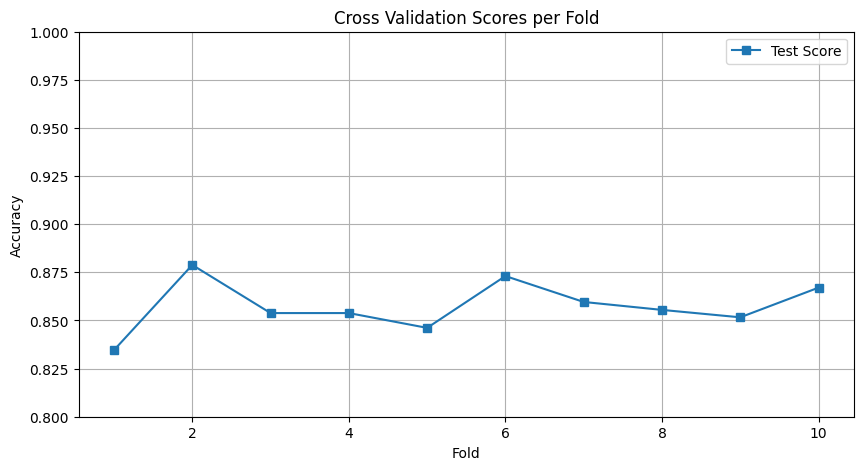

In [203]:
# Fold 번호
folds = range(1, len(scores['test_score']) + 1)

# 그래프 생성
plt.figure(figsize=(10, 5))
# plt.plot(folds, scores['train_score'], marker='o', label='Train Score', linestyle='--')
plt.plot(folds, scores['test_score'], marker='s', label='Test Score')
plt.title('Cross Validation Scores per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0)
plt.grid(True)
plt.legend()
plt.show()

## 하이퍼파라미터 튜닝

In [204]:
from sklearn.model_selection import GridSearchCV

params = {'min_impurity_decrease': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}

In [205]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)

In [206]:
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
                                                   0.0004, 0.0005]})

Text(0.5, 1.0, 'Grid Search Results')

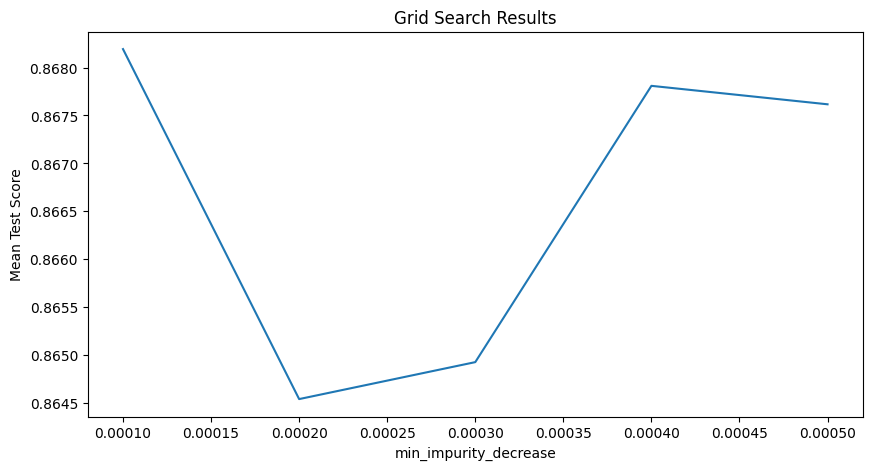

In [207]:
import matplotlib.pyplot as plt

results = gs.cv_results_
plt.figure(figsize=(10, 5))
plt.plot(params['min_impurity_decrease'], results['mean_test_score'])
plt.xlabel('min_impurity_decrease')
plt.ylabel('Mean Test Score')
plt.title('Grid Search Results')

In [208]:
dt = gs.best_estimator_
print(dt.score(train_input, train_target))

0.9615162593804117


In [209]:
print(gs.best_params_)

{'min_impurity_decrease': 0.0001}


In [210]:
print(gs.cv_results_['mean_test_score'])

[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


In [211]:
best_index = np.argmax(gs.cv_results_['mean_test_score'])
print(gs.cv_results_['params'][best_index])

{'min_impurity_decrease': 0.0001}


In [212]:
params = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),
          'max_depth': range(5, 20, 1),
          'min_samples_split': range(2, 100, 10)
          }

In [213]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

In [214]:
print(gs.best_params_)

{'max_depth': 14, 'min_impurity_decrease': np.float64(0.0004), 'min_samples_split': 12}


In [215]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8683865773302731


### 랜덤 서치

In [216]:
from scipy.stats import uniform, randint

In [217]:
rgen = randint(0, 10)
rgen.rvs(10)

array([5, 2, 8, 8, 7, 4, 0, 0, 4, 6])

In [218]:
np.unique(rgen.rvs(1000), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([101, 115,  91,  96,  98,  85, 121,  95,  98, 100]))

In [219]:
ugen = uniform(0, 1)
ugen.rvs(10)

array([0.6822049 , 0.46351904, 0.19112927, 0.6780602 , 0.51667637,
       0.88491963, 0.13653339, 0.73929298, 0.23636401, 0.52005347])

In [220]:
params = {'min_impurity_decrease': uniform(0.0001, 0.001),
          'max_depth': randint(20, 50),
          'min_samples_split': randint(2, 25),
          'min_samples_leaf': randint(1, 25),
          }

In [221]:
from sklearn.model_selection import RandomizedSearchCV

gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params,
                        n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x790ef4563150>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x790ef45608d0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x790ef4563c10>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x790ef4563790>},
                   random_state=42)

In [222]:
print(gs.best_params_)

{'max_depth': 39, 'min_impurity_decrease': np.float64(0.00034102546602601173), 'min_samples_leaf': 7, 'min_samples_split': 13}


In [223]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8695428296438884


In [224]:
dt = gs.best_estimator_

print(dt.score(test_input, test_target))

0.86


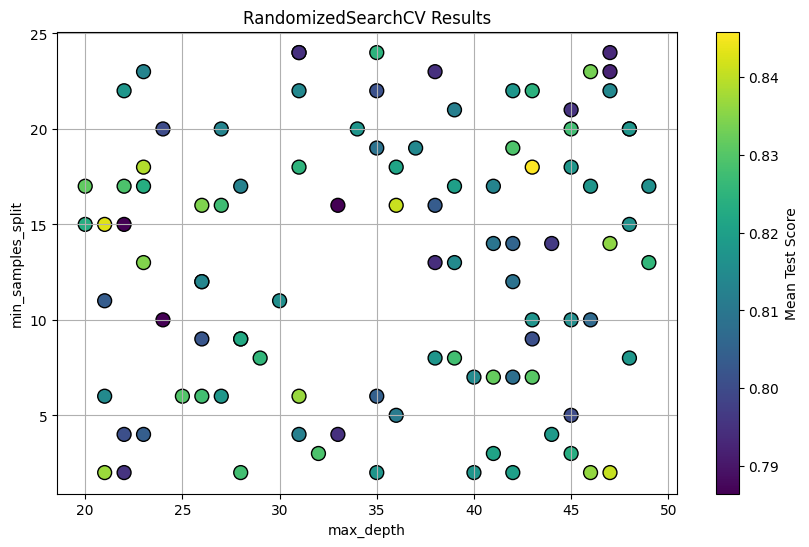

In [235]:
import matplotlib.pyplot as plt
import pandas as pd

# 결과를 DataFrame으로 변환
results = pd.DataFrame(gs.cv_results_)

# 파라미터와 성능 점수 추출
x = results['param_max_depth'].astype(int)
y = results['param_min_samples_split'].astype(int)
score = results['mean_test_score']

# 산점도 시각화 (matplotlib 사용)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, c=score, cmap='viridis', s=100, edgecolor='k')
plt.colorbar(scatter, label='Mean Test Score')  # colorbar 추가

# 레이블 및 타이틀
plt.xlabel('max_depth')
plt.ylabel('min_samples_split')
plt.title('RandomizedSearchCV Results')
plt.grid(True)
plt.show()


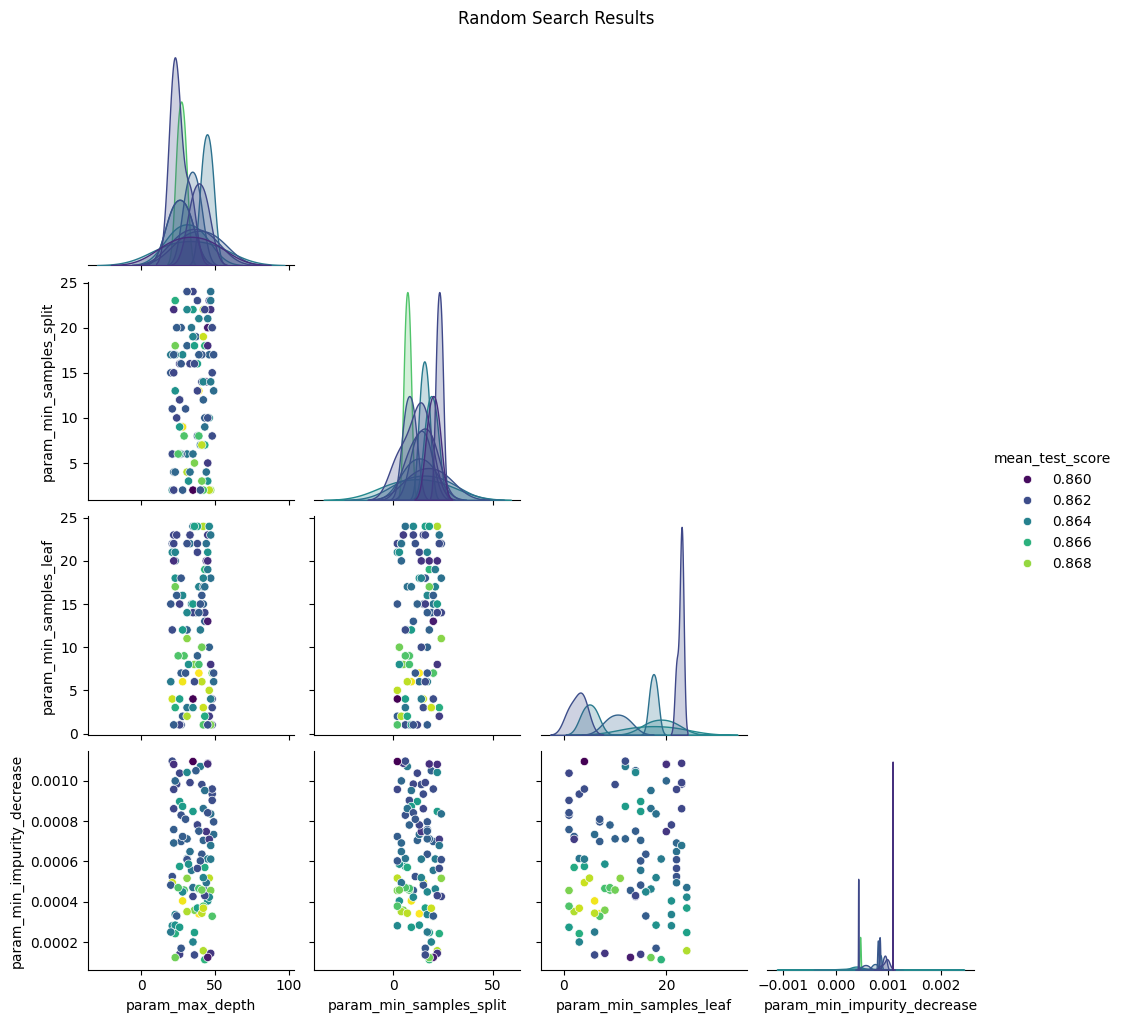

In [226]:
# 주요 파라미터들만 선택
plot_data = results[[
    'param_max_depth',
    'param_min_samples_split',
    'param_min_samples_leaf',
    'param_min_impurity_decrease',
    'mean_test_score'
]]

# pairplot으로 다중 변수 관계 시각화
sns.pairplot(plot_data, corner=True, diag_kind="kde", hue="mean_test_score", palette="viridis")
plt.suptitle("Random Search Results", y=1.02)
plt.show()

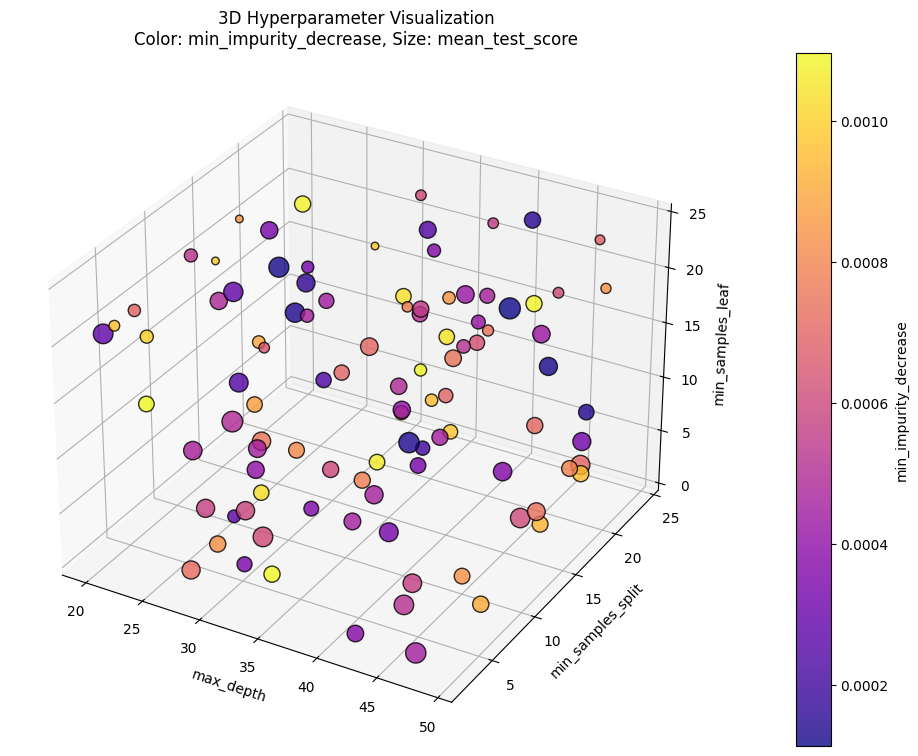

In [237]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# RandomizedSearchCV 결과 데이터프레임
results = pd.DataFrame(gs.cv_results_)

# 필요한 열 선택 및 타입 변환
df = results[['param_max_depth',
              'param_min_samples_split',
              'param_min_samples_leaf',
              'param_min_impurity_decrease',
              'mean_test_score']].copy()

df = df.astype({
    'param_max_depth': int,
    'param_min_samples_split': int,
    'param_min_samples_leaf': int,
    'param_min_impurity_decrease': float,
    'mean_test_score': float
})

# 3D 시각화
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# 축 좌표
x = df['param_max_depth']
y = df['param_min_samples_split']
z = df['param_min_samples_leaf']

# 점 색상: min_impurity_decrease 값
color = df['param_min_impurity_decrease']

# 점 크기: 성능 스코어
sizes = (df['mean_test_score'] - df['mean_test_score'].min()) / \
        (df['mean_test_score'].max() - df['mean_test_score'].min()) * 200 + 30

# 산점도
scatter = ax.scatter(
    x, y, z,
    c=color,
    s=sizes,
    cmap='plasma',
    edgecolor='k',
    alpha=0.8
)

# 컬러바 추가
cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('min_impurity_decrease')

# 라벨 설정
ax.set_xlabel('max_depth')
ax.set_ylabel('min_samples_split')
ax.set_zlabel('min_samples_leaf')
ax.set_title('3D Hyperparameter Visualization\nColor: min_impurity_decrease, Size: mean_test_score')

plt.show()


## 확인문제

In [227]:
gs = RandomizedSearchCV(DecisionTreeClassifier(splitter='random', random_state=42), params,
                        n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42,
                                                    splitter='random'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x790ef4563150>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x790ef45608d0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x790ef4563c10>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x790ef4563790>},
                   random_state=42)

In [228]:
print(gs.best_params_)
print(np.max(gs.cv_results_['mean_test_score']))

dt = gs.best_estimator_
print(dt.score(test_input, test_target))

{'max_depth': 43, 'min_impurity_decrease': np.float64(0.00011407982271508446), 'min_samples_leaf': 19, 'min_samples_split': 18}
0.8458726956392981
0.786923076923077
